In [ ]:
# ---------------------------------------------
# Imports and File Paths Setup
# ---------------------------------------------

# -----------------------------
# Data Handling Libraries
# -----------------------------
import pandas as pd   # For data manipulation
import numpy as np    # For numerical computations
import os             # For handling file paths

# -----------------------------
# Sentiment Analysis
# -----------------------------
from textblob import TextBlob  # For sentiment scoring of text

# -----------------------------
# Plotting Libraries
# -----------------------------
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns            # For enhanced plot aesthetics
sns.set(style="whitegrid")       # Apply a clean seaborn style

# -----------------------------
# File Paths
# -----------------------------
# Path to prepared stock data and raw analyst ratings
data_path = "../data"
stock_file = os.path.join(data_path, "yfinance_data", "AAPL_prepared.csv")
news_file = os.path.join(data_path, "raw_analyst_ratings.csv")


In [ ]:
# ---------------------------------------------
# 1. Load Stock Data
# ---------------------------------------------

# Load prepared stock data from CSV
df_stock = pd.read_csv(stock_file, index_col=0, parse_dates=True)

# Normalize the index to keep only the date (remove time component)
df_stock.index = pd.to_datetime(df_stock.index).normalize()

# Display a sample of the stock data
print("Stock data sample:")
print(df_stock.head())

# ---------------------------------------------
# 2. Load News Data
# ---------------------------------------------

# Load news/analyst ratings data
df_news = pd.read_csv(news_file, parse_dates=['date'])

# Remove timezone information and normalize to date only
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce') \
                      .dt.tz_localize(None) \
                      .dt.normalize()

# Display a sample of the news data
print("\nNews data sample:")
print(df_news.head())


Stock data sample:
                Open      High       Low     Close      Volume  MA_20  MA_50  \
Date                                                                           
2009-01-02  2.575630  2.730385  2.554037  2.721686   746015200    NaN    NaN   
2009-01-05  2.794266  2.884539  2.780469  2.836553  1181608400    NaN    NaN   
2009-01-06  2.877641  2.914229  2.770872  2.789767  1289310400    NaN    NaN   
2009-01-07  2.753477  2.774170  2.706990  2.729484   753048800    NaN    NaN   
2009-01-08  2.712090  2.793666  2.700393  2.780169   673500800    NaN    NaN   

            RSI_14  MACD  MACD_signal  MACD_hist  
Date                                              
2009-01-02     NaN   NaN          NaN        NaN  
2009-01-05     NaN   NaN          NaN        NaN  
2009-01-06     NaN   NaN          NaN        NaN  
2009-01-07     NaN   NaN          NaN        NaN  
2009-01-08     NaN   NaN          NaN        NaN  

News data sample:
   Unnamed: 0                               

In [ ]:
# ---------------------------------------------
# 3. Merge News with Stock Data
# ---------------------------------------------

# Merge the news DataFrame with the stock DataFrame on the date column
# - left_on='date' refers to the news DataFrame's date
# - right_index=True refers to the stock DataFrame's index
# - how='inner' keeps only rows with matching dates in both datasets
df_merged = pd.merge(
    df_news,
    df_stock,
    left_on='date',
    right_index=True,
    how='inner'
)

# Display a sample of the merged data
print("\nMerged data sample:")
print(df_merged.head())

# Display the shape of the merged DataFrame
print("\nMerged data shape:", df_merged.shape)



Merged data sample:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

        date stock       Open       High        Low      Close     Volume  \
0 2020-06-05     A  78.414533  80.451587  

In [ ]:
# ---------------------------------------------
# 4. Compute Sentiment for Each Headline
# ---------------------------------------------

# Use TextBlob to calculate sentiment polarity for each headline
# - Polarity ranges from -1 (negative) to +1 (positive)
df_merged['sentiment'] = df_merged['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Display a sample of headlines with their sentiment scores
print("\nSentiment sample:")
print(df_merged[['headline', 'sentiment']].head())



Sentiment sample:
                                            headline  sentiment
0            Stocks That Hit 52-Week Highs On Friday        0.0
1         Stocks That Hit 52-Week Highs On Wednesday        0.0
2                      71 Biggest Movers From Friday        0.0
3       46 Stocks Moving In Friday's Mid-Day Session        0.0
4  B of A Securities Maintains Neutral on Agilent...        0.0


In [ ]:
# ---------------------------------------------
# 5. Aggregate Daily Sentiment
# ---------------------------------------------

# Group merged data by date and calculate the average sentiment for each day
daily_sentiment = df_merged.groupby('date')['sentiment'].mean().to_frame()

# Rename the column for clarity
daily_sentiment.rename(columns={'sentiment': 'avg_sentiment'}, inplace=True)

# Display a sample of the daily average sentiment
print("\nDaily average sentiment sample:")
print(daily_sentiment.head())



Daily average sentiment sample:
            avg_sentiment
date                     
2011-04-27       0.000000
2011-04-28       0.068182
2011-04-29       0.166667
2011-05-02      -0.009259
2011-05-03       0.000000


In [ ]:
# ---------------------------------------------
# 6. Compute Daily Returns
# ---------------------------------------------

# Calculate daily percentage change in closing price
df_stock['daily_return'] = df_stock['Close'].pct_change()

# Extract the daily returns into a separate DataFrame
daily_returns = df_stock[['daily_return']]

# Display a sample of daily returns
print("\nDaily returns sample:")
print(daily_returns.head())



Daily returns sample:
            daily_return
Date                    
2009-01-02           NaN
2009-01-05      0.042204
2009-01-06     -0.016494
2009-01-07     -0.021609
2009-01-08      0.018570


In [ ]:
# ---------------------------------------------
# 7. Merge Sentiment and Returns
# ---------------------------------------------

# Merge daily average sentiment with daily returns on the date index
# - left_index and right_index ensure the merge is on the date
# - how='inner' keeps only dates present in both datasets
df_final = pd.merge(
    daily_sentiment,
    daily_returns,
    left_index=True,
    right_index=True,
    how='inner'
)

# Display a sample of the final dataset
print("\nFinal dataset sample:")
print(df_final.head())



Final dataset sample:
            avg_sentiment  daily_return
2011-04-27       0.000000     -0.000770
2011-04-28       0.068182     -0.009710
2011-04-29       0.166667      0.009748
2011-05-02      -0.009259     -0.010997
2011-05-03       0.000000      0.005545


In [ ]:
# ---------------------------------------------
# 8. Compute Correlation Between Sentiment and Returns
# ---------------------------------------------

# Calculate the Pearson correlation coefficient
# between daily average sentiment and daily stock returns
correlation = df_final['avg_sentiment'].corr(df_final['daily_return'])

# Display the correlation value
print(f"Pearson correlation between sentiment and returns: {correlation:.4f}")


Pearson correlation between sentiment and returns: -0.0028


<Figure size 1400x500 with 0 Axes>

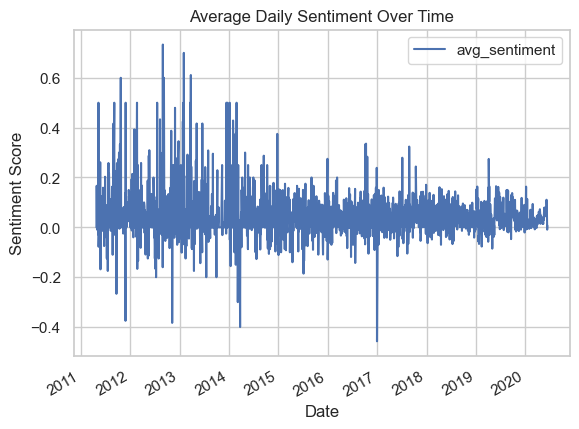

In [16]:
plt.figure(figsize=(14,5))
daily_sentiment.plot()
plt.title("Average Daily Sentiment Over Time")
plt.ylabel("Sentiment Score")
plt.xlabel("Date")
plt.show()


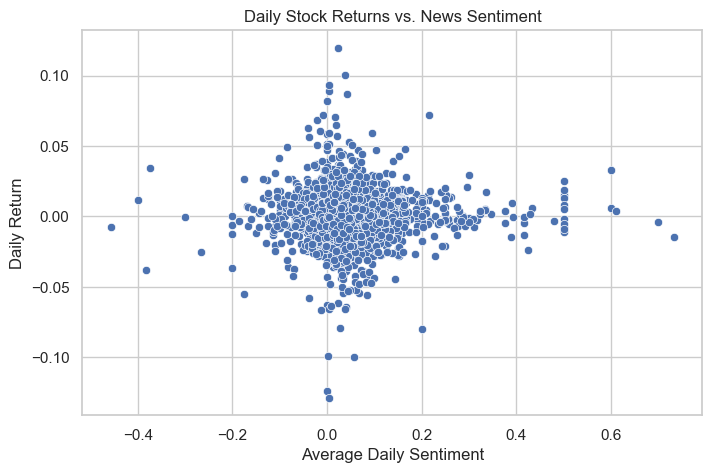

In [ ]:
# ---------------------------------------------
# Scatter Plot: Sentiment vs Daily Returns
# ---------------------------------------------

# Set figure size for better readability
plt.figure(figsize=(8, 5))

# Create a scatter plot showing the relationship between sentiment and stock returns
sns.scatterplot(x='avg_sentiment', y='daily_return', data=df_final)

# Add title and axis labels
plt.title("Daily Stock Returns vs. News Sentiment")
plt.xlabel("Average Daily Sentiment")
plt.ylabel("Daily Return")

# Display the plot
plt.show()


In [ ]:
# ---------------------------------------------
# Save Final Dataset with Sentiment and Returns
# ---------------------------------------------

# Export the final DataFrame containing daily sentiment and stock returns to a CSV file
df_final.to_csv(os.path.join(data_path, "AAPL_sentiment_returns.csv"))
